In [ ]:
# 2. Device CPU/GPU + wymuszenie inicjalizacji CUDA
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# wymuszenie inicjalizacji CUDA
if device.type == "cuda":
    _ = torch.zeros(1, device=device)
    print(torch.cuda.get_device_name(0))

Using device: cuda
NVIDIA GeForce RTX 2070 with Max-Q Design


In [12]:
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.image import show_cam_on_image
import matplotlib.pyplot as plt
import numpy as np

In [16]:
# 1. Grad-CAM
cam = GradCAM(
    model=model,
    target_layers=[target_layer]
)

In [ ]:
from torchvision import transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader

IMAGE_SIZE = 128
BATCH_SIZE = 32

test_transforms = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5]*3, std=[0.5]*3),
])

In [24]:
# 3. test dataset + loader
TEST_DIR = "./real-and-fake-detection/real_vs_fake/real-vs-fake/test"

test_dataset = ImageFolder(
    root=TEST_DIR,
    transform=test_transforms
)

test_loader = DataLoader(
    test_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=4,
    pin_memory=True
)

print("Classes:", test_dataset.classes)

Classes: ['fake', 'real']


### Grad CAM

In [110]:
import torchvision.transforms as transforms
from PIL import Image

# 2. Define the image transformations required for the ResNet18 model.
preprocess = transforms.Compose([
    transforms.Resize(128),
    # transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

print("Necessary libraries imported and image transformations defined.")

Necessary libraries imported and image transformations defined.


In [111]:
image_path = "./real-and-fake-detection/real_vs_fake/real-vs-fake/test/real/69952.jpg" 

try:
    # 3. Load a sample image.
    img = Image.open(image_path).convert('RGB')
    print(f"Image loaded successfully from {image_path}.")

    # 4. Apply the defined transformations.
    img_tensor = preprocess(img)
    print("Image transformations applied.")

    # 5. Add a batch dimension.
    batch_img_tensor = img_tensor.unsqueeze(0).to(device) # Add a batch dimension (C, H, W) -> (1, C, H, W)
    print(f"Batch dimension added. Shape: {batch_img_tensor.shape}")

except FileNotFoundError:
    print(f"Error: The image file was not found at {image_path}. Please make sure the path is correct.")
except Exception as e:
    print(f"An error occurred during image loading or preprocessing: {e}")

Image loaded successfully from ./real-and-fake-detection/real_vs_fake/real-vs-fake/test/real/69952.jpg.
Image transformations applied.
Batch dimension added. Shape: torch.Size([1, 3, 128, 128])


In [116]:
import torchvision.models as models
import torch

from pytorch_grad_cam import GradCAM

# 1. Load a pre-trained ResNet18 model.
model = models.resnet18(weights="DEFAULT")
model.fc = torch.nn.Sequential(
    torch.nn.Linear(model.fc.in_features, 1),
    torch.nn.Sigmoid()
)

model.load_state_dict(torch.load("checkpoints/best_model-02.pt", map_location=device))
model.to(device)
model.eval()
print("Best model loaded for evaluation.")

# 3. Identify the target layer for Grad-CAM.
# For ResNet18, a common choice is the last convolutional layer in layer4.
target_layer = model.layer4[-1]
print(f"Target layer identified: {target_layer}")

# 4. Instantiate the GradCAM explainer, removing the 'use_cuda' argument.
cam = GradCAM(model=model, target_layers=[target_layer])
print("GradCAM explainer instantiated.")

Best model loaded for evaluation.
Target layer identified: BasicBlock(
  (conv1): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (conv2): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn2): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)
GradCAM explainer instantiated.


In [58]:
# 5. Generate the heatmap.
# INPUT
batch_img_tensor = batch_img_tensor.to(device)

In [59]:
# not needed anymore
class LogitBeforeSigmoid:
    def __call__(self, model_output):
        return model_output.squeeze()

In [60]:
import torch
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget

# Store the original final layer (which includes Sigmoid)
original_fc = model.fc

# Temporarily replace the final layer to remove the Sigmoid activation
# We want to compute gradients on the raw logits before the sigmoid.
# The Sequential contains (Linear, Sigmoid). We take just the Linear layer.
model.fc = original_fc[0]

In [ ]:
# TARGET
# Define the target for Grad-CAM. For a binary classifier with a single output (logit),
# we typically want to target the prediction for one of the classes.
# If the model is predicting the probability of class 1, we use ClassifierOutputTarget(0)
# to get the CAM for that single output neuron's logit.
targets = [ClassifierOutputTarget(0)]

# Perform a forward pass to get the raw logits
output_logits = model(batch_img_tensor)

# Generate the heatmap using Grad-CAM with the modified model and targets
grayscale_cam = cam(
    input_tensor=batch_img_tensor,
    targets=targets
)[0]

# Restore the original final layer (with Sigmoid) for proper predictions
model.fc = original_fc

# Now, get the actual prediction with sigmoid
output_prediction = model(batch_img_tensor)

print("Prediction (logit):", output_logits.item())
print("Prediction (probability):", output_prediction.item())
print(f"Grad-CAM heatmap generated with shape: {grayscale_cam.shape}")

Prediction (logit): 31.55255889892578
Prediction (probability): 1.0
Grad-CAM heatmap generated with shape: (224, 224)


In [62]:
print("CAM min:", grayscale_cam.min())
print("CAM max:", grayscale_cam.max())
print("CAM mean:", grayscale_cam.mean())

CAM min: 0.0
CAM max: 0.9999999
CAM mean: 0.41182515


In [ ]:
import matplotlib.pyplot as plt
from pytorch_grad_cam.utils.image import show_cam_on_image
import numpy as np
import torchvision.transforms as transforms

# === 3. Normalizacja heatmapy (WAŻNE!) ===
grayscale_cam = grayscale_cam - grayscale_cam.min()
grayscale_cam = grayscale_cam / (grayscale_cam.max() + 1e-8)

# ===== VISUALIZATION PIPELINE (NO NORMALIZE!) =====
vis_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
])

# PIL -> RGB [0,1]
vis_img = vis_transform(img)
rgb_img_for_overlay = np.array(vis_img, dtype=np.float32) / 255.0

# sanity check 
print("RGB min/max:", rgb_img_for_overlay.min(), rgb_img_for_overlay.max())
print("CAM min/max:", grayscale_cam.min(), grayscale_cam.max())

# === 4. Overlay ===
visualization = show_cam_on_image(
    rgb_img_for_overlay,
    grayscale_cam,
    use_rgb=True
)

# === 5. WYŚWIETLANIE ===
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.imshow(rgb_img_for_overlay)
plt.title("Original image (224x224)")
plt.axis("off")

plt.subplot(1, 3, 2)
plt.imshow(grayscale_cam, cmap="jet")
plt.title("Grad-CAM heatmap")
plt.colorbar()
plt.axis("off")

plt.subplot(1, 3, 3)
plt.imshow(visualization)
plt.title("Grad-CAM overlay")
plt.axis("off")

plt.tight_layout()
plt.show()


#### koniec Grad-CAM

więcej testów GradCAM

In [113]:
import os
import random

# 2. Define the base directory for your test images
test_dir = './real-and-fake-detection/real_vs_fake/real-vs-fake/test'

# 3. Construct the full paths to the 'real' and 'fake' subdirectories
real_dir = os.path.join(test_dir, 'real')
fake_dir = os.path.join(test_dir, 'fake')

print(f"Real images directory: {real_dir}")
print(f"Fake images directory: {fake_dir}")

Real images directory: ./real-and-fake-detection/real_vs_fake/real-vs-fake/test\real
Fake images directory: ./real-and-fake-detection/real_vs_fake/real-vs-fake/test\fake


In [114]:
import os
import random

# 4. Get a list of all image file paths in both directories
real_image_files = [os.path.join(real_dir, f) for f in os.listdir(real_dir) if f.endswith(('.png', '.jpg', '.jpeg'))]
fake_image_files = [os.path.join(fake_dir, f) for f in os.listdir(fake_dir) if f.endswith(('.png', '.jpg', '.jpeg'))]

# 5. Randomly select 4 image paths from each list
num_samples = 4
selected_real_samples = random.sample(real_image_files, min(num_samples, len(real_image_files)))
selected_fake_samples = random.sample(fake_image_files, min(num_samples, len(fake_image_files)))

# 6. Create a list of dictionaries to store the selected images and their true labels
selected_images_info = []
for path in selected_real_samples:
    selected_images_info.append({'path': path, 'label': 0}) # 0 for real
for path in selected_fake_samples:
    selected_images_info.append({'path': path, 'label': 1}) # 1 for fake

# 7. Print the selected_images_info to verify the paths and labels
print("Selected images and their true labels:")
for item in selected_images_info:
    print(item)

Selected images and their true labels:
{'path': './real-and-fake-detection/real_vs_fake/real-vs-fake/test\\real\\68273.jpg', 'label': 0}
{'path': './real-and-fake-detection/real_vs_fake/real-vs-fake/test\\real\\18095.jpg', 'label': 0}
{'path': './real-and-fake-detection/real_vs_fake/real-vs-fake/test\\real\\37494.jpg', 'label': 0}
{'path': './real-and-fake-detection/real_vs_fake/real-vs-fake/test\\real\\04487.jpg', 'label': 0}
{'path': './real-and-fake-detection/real_vs_fake/real-vs-fake/test\\fake\\Z25T73SMI0.jpg', 'label': 1}
{'path': './real-and-fake-detection/real_vs_fake/real-vs-fake/test\\fake\\SL00AMYUF5.jpg', 'label': 1}
{'path': './real-and-fake-detection/real_vs_fake/real-vs-fake/test\\fake\\2QO9K0ILIQ.jpg', 'label': 1}
{'path': './real-and-fake-detection/real_vs_fake/real-vs-fake/test\\fake\\AV7F0USBRY.jpg', 'label': 1}


In [117]:
# wrapper do Grad-CAM
class ModelWithoutSigmoid(torch.nn.Module):
    def __init__(self, model):
        super().__init__()
        self.features = torch.nn.Sequential(*list(model.children())[:-1])
        self.fc = model.fc[0]  # Linear only

    def forward(self, x):
        x = self.features(x)
        x = torch.flatten(x, 1)
        return self.fc(x)

In [118]:
cam_model = ModelWithoutSigmoid(model)
cam_model.eval()

ModelWithoutSigmoid(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_runnin

In [119]:
target_layer = model.layer4[-1]
cam = GradCAM(model=cam_model, target_layers=[target_layer])

In [122]:
import matplotlib.pyplot as plt
import numpy as np
from pytorch_grad_cam.utils.image import show_cam_on_image
import torchvision.transforms as transforms

def display_grad_cam(original_image, grad_cam_heatmap, true_label_str, predicted_label_str, confidence):
    # 2. Normalize the grad_cam_heatmap
    grayscale_cam_normalized = grad_cam_heatmap - grad_cam_heatmap.min()
    grayscale_cam_normalized = grayscale_cam_normalized / (grayscale_cam_normalized.max() + 1e-8)

    # 3. Apply the defined transformations for visualization
    # vis_transform was defined in a previous cell, ensure it's accessible or redefine if necessary.
    # For simplicity, assuming vis_transform is globally available as per previous execution.
    vis_transform = transforms.Compose([
        transforms.Resize(128),
        # transforms.CenterCrop(224),
    ])
    
    vis_img = vis_transform(original_image)
    rgb_img_for_overlay = np.array(vis_img, dtype=np.float32) / 255.0

    # 4. Create the overlay
    visualization = show_cam_on_image(
        rgb_img_for_overlay,
        grayscale_cam_normalized,
        use_rgb=True
    )

    # 5. Create a Matplotlib figure with three subplots
    plt.figure(figsize=(15, 5))

    # 6. Display original image
    plt.subplot(1, 3, 1)
    plt.imshow(rgb_img_for_overlay)
    plt.title("Original image")
    plt.axis("off")

    # 7. Display Grad-CAM heatmap
    plt.subplot(1, 3, 2)
    plt.imshow(grayscale_cam_normalized, cmap="jet")
    plt.title("Grad-CAM heatmap")
    plt.colorbar()
    plt.axis("off")

    # 8. Display Grad-CAM overlay with prediction and true label
    plt.subplot(1, 3, 3)
    plt.imshow(visualization)
    plt.title(
        f'Grad-CAM overlay\n'
        f'image: {true_label_str}, prediction: {predicted_label_str}\n'
        f'confidence: {confidence * 100:.4f}%')
    plt.axis("off")

    # 9. Adjust layout and display plot
    plt.tight_layout()
    plt.show()

print("The 'display_grad_cam' function has been defined.")

The 'display_grad_cam' function has been defined.


In [127]:
from torchvision import transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader

IMAGE_SIZE = 128
BATCH_SIZE = 32

test_transforms = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5]*3, std=[0.5]*3),
])

In [ ]:
# 3. test dataset + loader
TEST_DIR = "./real-and-fake-detection/real_vs_fake/real-vs-fake/test"

test_dataset = ImageFolder(
    root=TEST_DIR,
    transform=test_transforms
)

test_loader = DataLoader(
    test_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=4,
    pin_memory=True
)

print("Classes:", test_dataset.classes)

Classes: ['fake', 'real']


In [ ]:
# poprawiłam sobie wyświetlanie confidence, ale nie działa jeszcze nałożenie Grad-CAM XD
import torch
import matplotlib.pyplot as plt
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image

# === ustawienia ===
model.eval()
target_layer = model.layer4[-1]   # ostatnia warstwa konwolucyjna ResNet18
cam = GradCAM(model=model, target_layers=[target_layer])

LABEL_MAP = {0: "real", 1: "fake"}  # zgodne z DataLoaderem

# === wybierz batch z test_loader ===
batch = next(iter(test_loader))
images, labels = batch
batch_size = images.size(0)
images = images.to(device)
labels = labels.to(device).unsqueeze(1)

# === predykcje modelu ===
with torch.no_grad():
    outputs = model(images)                  # P(class=1) = fake
    preds = (outputs > 0.5).float()
    confidences = torch.where(preds==1, outputs, 1 - outputs)

# przenieś do CPU
images = images.cpu()
labels = labels.cpu()
preds = preds.cpu()
confidences = confidences.cpu()

# funkcja konwersji etykiety 0/1 → tekst
def label_to_text(label):
    return LABEL_MAP[int(label)]

# === wyświetlanie wszystkich obrazów batchowo ===
num_to_show = min(batch_size, 8)  # maksymalnie 8 obrazów na figurę
fig, axes = plt.subplots(num_to_show, 3, figsize=(12, 4*num_to_show))

for i in range(num_to_show):
    img_tensor = images[i].unsqueeze(0).to(device)
    pred = preds[i].item()
    conf = confidences[i].item()
    label = labels[i].item()

    # Grad-CAM
    grayscale_cam = cam(input_tensor=img_tensor, targets=[ClassifierOutputTarget(0)])[0]

    # przygotowanie obrazu do overlay
    rgb_img = images[i].permute(1, 2, 0).numpy()
    rgb_img = (rgb_img * 0.5 + 0.5)  # undo normalization
    overlay = show_cam_on_image(rgb_img, grayscale_cam, use_rgb=True)

    # wykresy
    ax_orig = axes[i, 0] if num_to_show > 1 else axes[0]
    ax_heat = axes[i, 1] if num_to_show > 1 else axes[1]
    ax_overlay = axes[i, 2] if num_to_show > 1 else axes[2]

    ax_orig.imshow(rgb_img)
    ax_orig.set_title(f"Original: {label_to_text(label)}")
    ax_orig.axis("off")

    ax_heat.imshow(grayscale_cam, cmap="jet")
    ax_heat.set_title("Grad-CAM heatmap")
    ax_heat.axis("off")

    ax_overlay.imshow(overlay)
    ax_overlay.set_title(f"Prediction: {label_to_text(pred)}\nConfidence: {conf*100:.2f}%")
    ax_overlay.axis("off")

plt.tight_layout()
plt.show()


In [ ]:
import torch
import matplotlib.pyplot as plt
import numpy as np
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image

# === ustawienia ===
model.eval()
target_layer = model.layer4[-1]   # ostatnia warstwa konwolucyjna ResNet18
cam = GradCAM(model=model, target_layers=[target_layer])

LABEL_MAP = {0: "real", 1: "fake"}  # zgodne z DataLoaderem

# === wybierz kilka próbek z test_loader ===
num_samples = 8
images_list, labels_list = [], []

# pobieramy próbki batchami
while len(images_list) < num_samples:
    x, y = next(iter(test_loader))  # iterator restartuje się automatycznie
    batch_size = x.size(0)
    remaining = num_samples - len(images_list)
    select_n = min(batch_size, remaining)
    indices = torch.randperm(batch_size)[:select_n]

    images_list.append(x[indices])
    labels_list.append(y[indices])

# połącz batch
images = torch.cat(images_list, dim=0).to(device)
labels = torch.cat(labels_list, dim=0).to(device).unsqueeze(1)

# === predykcje modelu ===
with torch.no_grad():
    outputs = model(images)                  # P(class=1) = fake
    preds = (outputs > 0.5).float()
    confidences = torch.where(preds==1, outputs, 1 - outputs)

# przenieś do CPU do wizualizacji
images = images.cpu()
labels = labels.cpu()
preds = preds.cpu()
confidences = confidences.cpu()

# funkcja konwersji etykiety 0/1 → tekst
def label_to_text(label):
    return LABEL_MAP[int(label)]

# === wyświetlanie Grad-CAM dla każdej próbki ===
for i in range(num_samples):
    img_tensor = images[i].unsqueeze(0).to(device)  # dodaj batch dim
    label = labels[i].item()
    pred = preds[i].item()
    conf = confidences[i].item()

    # Grad-CAM
    grayscale_cam = cam(input_tensor=img_tensor, targets=[ClassifierOutputTarget(0)])[0]

    # przygotowanie obrazu do overlay
    rgb_img_for_overlay = images[i].permute(1, 2, 0).numpy()
    rgb_img_for_overlay = (rgb_img_for_overlay * 0.5 + 0.5)  # undo normalize
    visualization = show_cam_on_image(rgb_img_for_overlay, grayscale_cam, use_rgb=True)

    # wyświetlanie
    plt.figure(figsize=(12,4))
    
    plt.subplot(1,3,1)
    plt.imshow(rgb_img_for_overlay)
    plt.title(f"Original image\n{label_to_text(label)}")
    plt.axis("off")
    
    plt.subplot(1,3,2)
    plt.imshow(grayscale_cam, cmap="jet")
    plt.title("Grad-CAM heatmap")
    plt.axis("off")
    
    plt.subplot(1,3,3)
    plt.imshow(visualization)
    plt.title(f"Grad-CAM overlay\nprediction: {label_to_text(pred)}\nconfidence: {conf*100:.2f}%")
    plt.axis("off")
    
    plt.tight_layout()
    plt.show()

In [ ]:
# a to nie działa najlepiej
from PIL import Image
import torch
import numpy as np
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget

model.eval()

LABEL_MAP = {
    0: "fake",
    1: "true"
}

for image_info in selected_images_info:
    image_path = image_info['path']
    true_label = image_info['label']  # 0 or 1

    try:
        # 3. Load the image
        original_pil_img = Image.open(image_path).convert('RGB')

        # 4. Preprocess + batch
        img_tensor = preprocess(original_pil_img)
        batch_img_tensor = img_tensor.unsqueeze(0).to(device)

        # 5. Store original fc (with Sigmoid)
        original_fc = model.fc

        # 6. Remove Sigmoid for Grad-CAM
        model.fc = original_fc[0]

        # 7. Grad-CAM target (single output neuron)
        targets = [ClassifierOutputTarget(0)]

        # 8. Generate Grad-CAM
        grayscale_cam = cam(
            input_tensor=batch_img_tensor,
            targets=[ClassifierOutputTarget(0)]
        )[0]

        # 9. Restore Sigmoid
        model.fc = original_fc

        # 10. Prediction
        with torch.no_grad():
            prob_fake = model(batch_img_tensor).item()   # po Sigmoid

            predicted_label = 1 if prob_fake >= 0.5 else 0
            confidence = prob_fake if predicted_label == 1 else (1 - prob_fake)

            LABEL_MAP = {
                0: "real",
                1: "fake"
            }

            predicted_label_str = LABEL_MAP[predicted_label]
            true_label_str = LABEL_MAP[true_label]


        # 11. Display
        display_grad_cam(
            original_image=original_pil_img,
            grad_cam_heatmap=grayscale_cam,
            true_label_str=true_label_str,
            predicted_label_str=predicted_label_str,
            confidence=confidence,
        )
    
    except FileNotFoundError:
        print(f"Error: Image not found at {image_path}")
    except Exception as e:
        print(f"An error occurred for image {image_path}: {e}")

print("Grad-CAM visualization completed for all selected images.")

In [ ]:
# to tylko jeden przykład
true_label = 0  # Assuming 'real' corresponds to label 0 based on the image path '/content/real-and-fake-detection/real-vs-fake/real-vs-fake/test/real/06107.jpg'
display_grad_cam(original_image=img, 
                 grad_cam_heatmap=grayscale_cam, 
                 predicted_probability=output_prediction.item(), 
                 true_label=true_label)

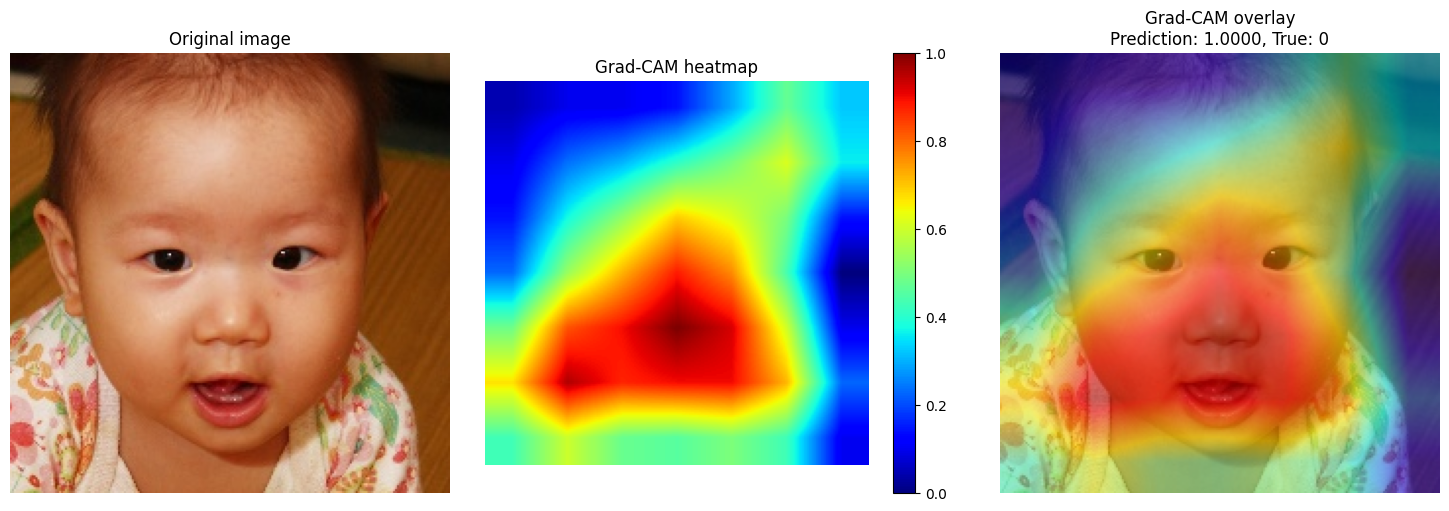

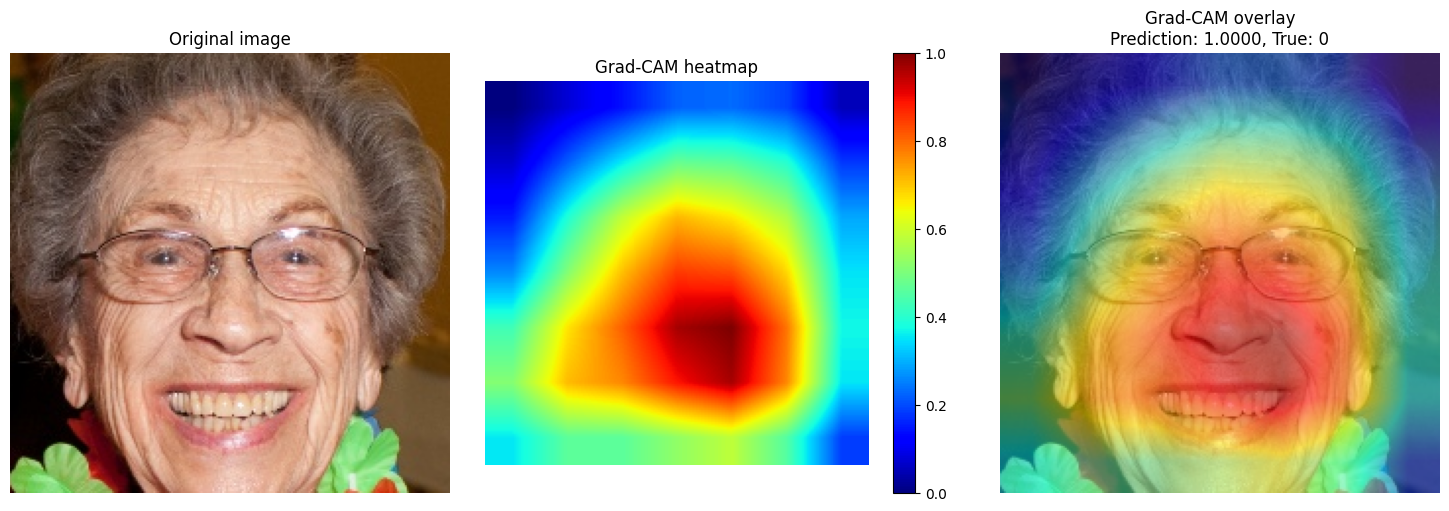

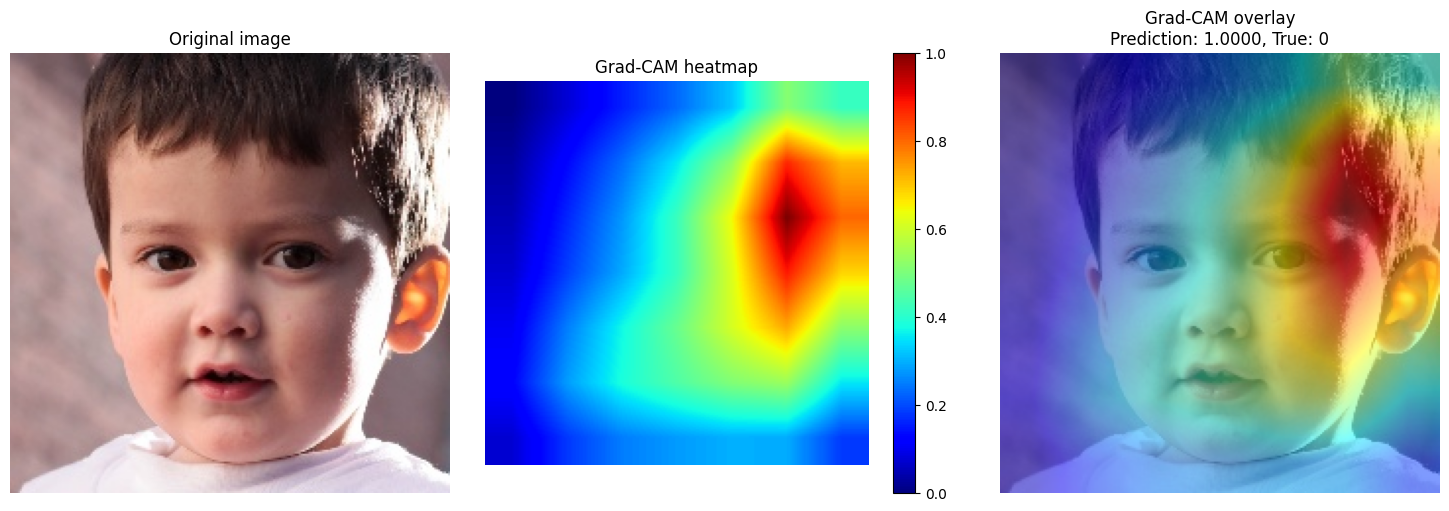

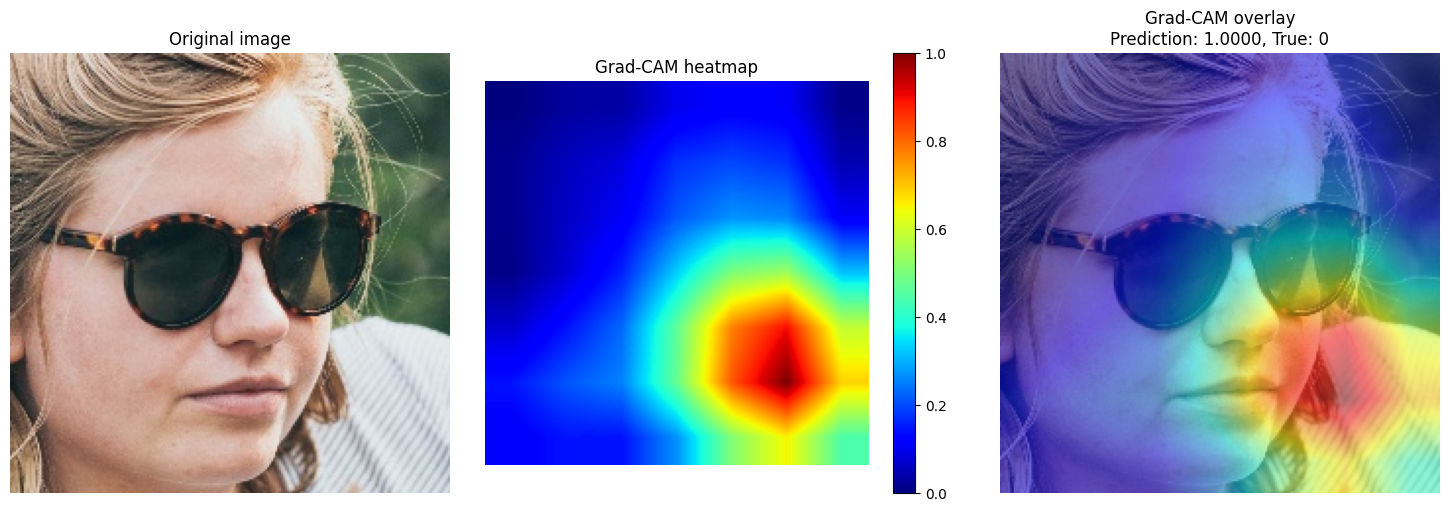

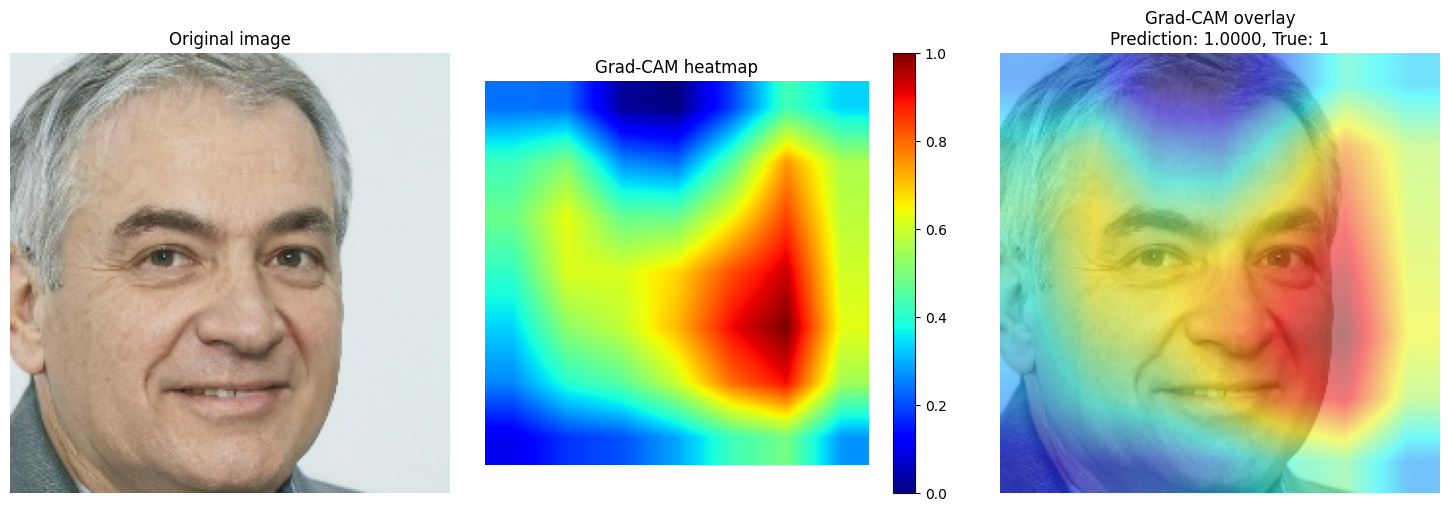

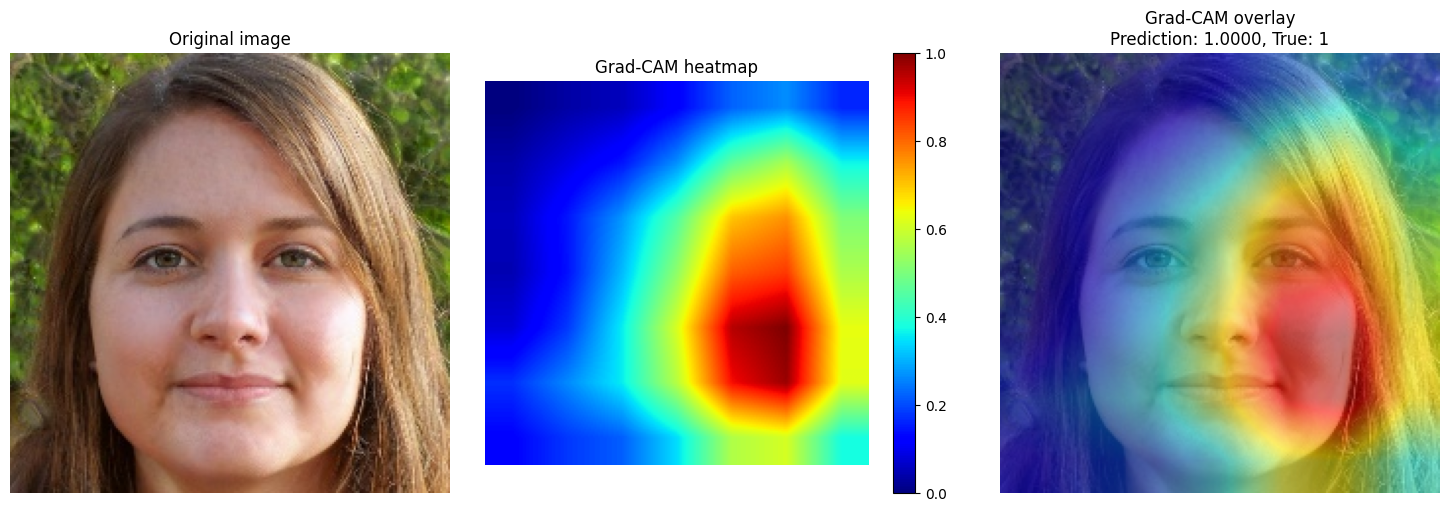

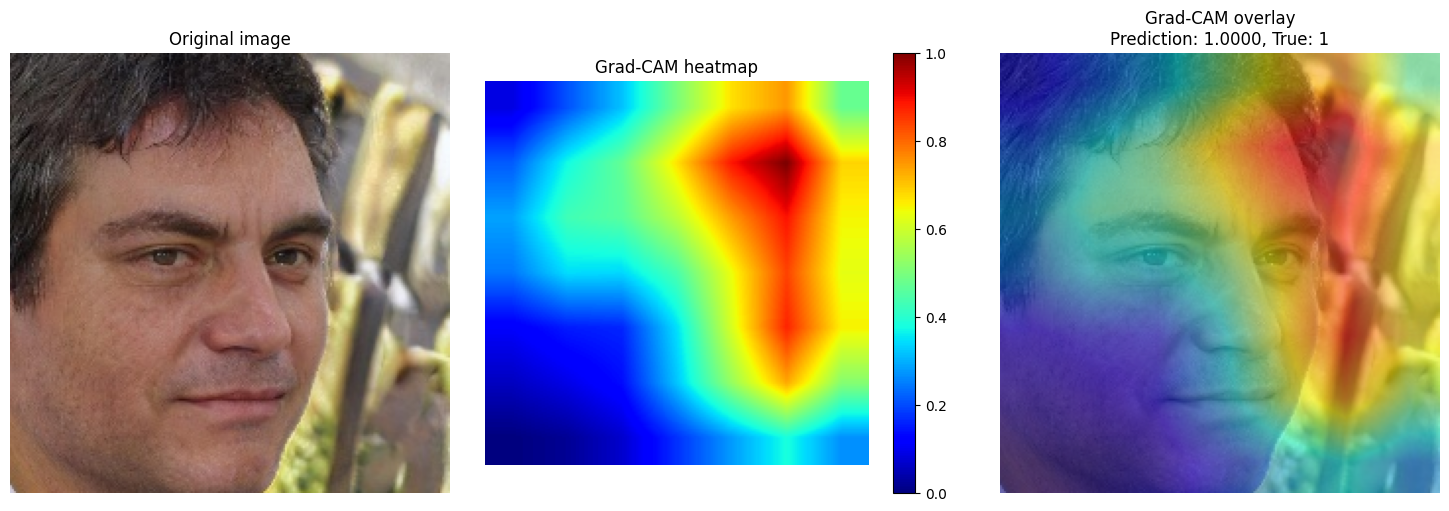

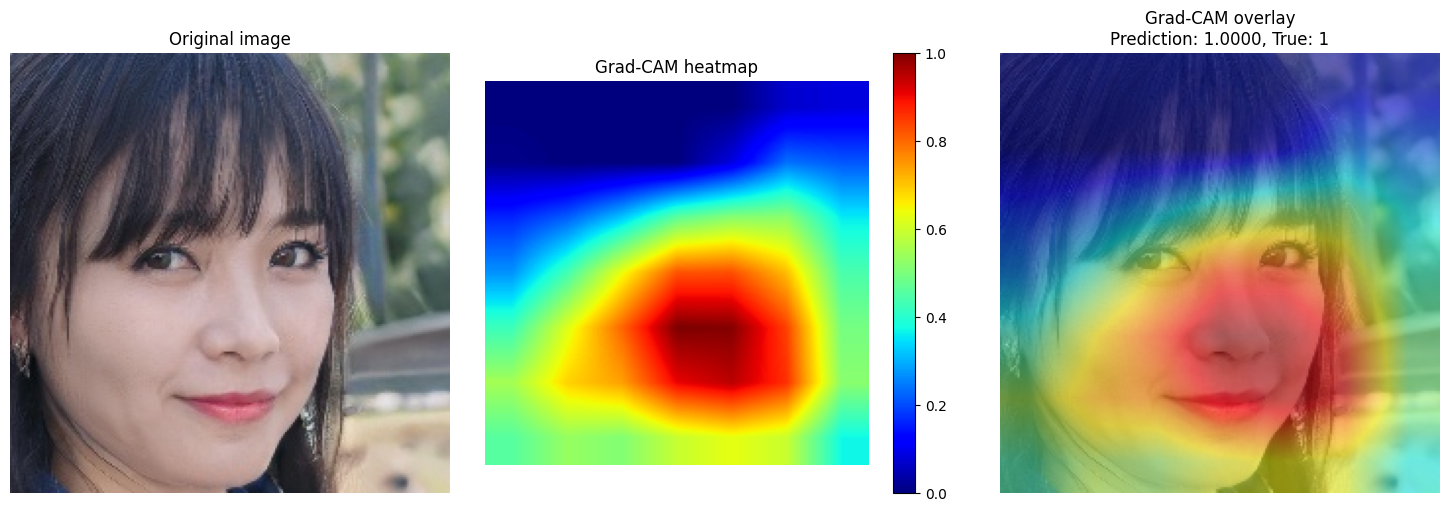

Grad-CAM visualization completed for all selected images.


In [81]:
from PIL import Image
import torch
import numpy as np
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget

# Ensure model is in evaluation mode
model.eval()

# Loop through each selected image
for image_info in selected_images_info:
    image_path = image_info['path']
    true_label = image_info['label']

    try:
        # 3. Load the image
        original_pil_img = Image.open(image_path).convert('RGB')

        # 4. Apply preprocessing and add batch dimension
        img_tensor = preprocess(original_pil_img)
        batch_img_tensor = img_tensor.unsqueeze(0).to(device)

        # 5. Store the original final layer (which includes Sigmoid)
        original_fc = model.fc

        # 6. Temporarily replace the final layer to remove the Sigmoid activation
        model.fc = original_fc[0]

        # 7. Define targets for Grad-CAM
        targets = [ClassifierOutputTarget(0)]

        # 8. Generate the Grad-CAM heatmap
        grayscale_cam = cam(
            input_tensor=batch_img_tensor,
            targets=targets
        )[0]

        # 9. Restore the original final layer (with Sigmoid) for proper predictions
        model.fc = original_fc

        # 10. Get the model's prediction probability
        predicted_probability = model(batch_img_tensor).item()

        # 11. Call the display_grad_cam function
        display_grad_cam(original_image=original_pil_img,
                         grad_cam_heatmap=grayscale_cam,
                         predicted_probability=predicted_probability,
                         true_label=true_label)

    except FileNotFoundError:
        print(f"Error: Image not found at {image_path}")
    except Exception as e:
        print(f"An error occurred for image {image_path}: {e}")

print("Grad-CAM visualization completed for all selected images.")

koniec
---

In [ ]:
images.requires_grad = True
outputs = model(images)

score = outputs.sum()
model.zero_grad()
score.backward()

saliency = images.grad.abs().max(dim=1)[0]

In [ ]:
plt.imshow(saliency[i].cpu(), cmap="hot")
plt.title("Saliency Map")
plt.axis("off")
plt.show()

In [ ]:
# integrated gradients
from captum.attr import IntegratedGradients

In [ ]:
ig = IntegratedGradients(model)

attr = ig.attribute(
    images,
    target=0,
    n_steps=50
)

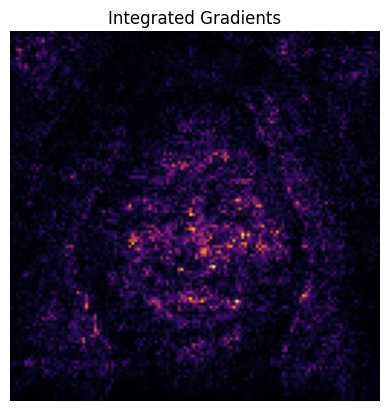

In [ ]:
ig_map = (
    attr[i]
    .abs()
    .sum(dim=0)
    .detach()
    .cpu()
)

ig_map = (ig_map - ig_map.min()) / (ig_map.max() + 1e-8)

plt.imshow(ig_map, cmap="inferno")
plt.title("Integrated Gradients")
plt.axis("off")
plt.show()

In [ ]:
from captum.attr import Occlusion

In [ ]:
occlusion = Occlusion(model)

attr_occ = occlusion.attribute(
    images,
    strides=(3, 15, 15),
    sliding_window_shapes=(3, 30, 30),
    target=0
)

In [ ]:
occ_map = attr_occ[i].abs().sum(dim=0).cpu()
plt.imshow(occ_map, cmap="viridis")
plt.title("Occlusion Sensitivity")
plt.axis("off")
plt.show()

XAI dla błędów modelu

In [ ]:
# błędny przykad
model.eval()
for x, y in test_loader:
    x, y = x.to(device), y.to(device).unsqueeze(1)
    preds = (model(x) > 0.5).float()
    mask = preds != y
    if mask.any():
        error_img = x[mask][0].unsqueeze(0)
        error_label = y[mask][0]
        break

# Grad-CAM dla błędnie sklasyfikowanego obrazu
# IG dla błędnie sklasyfikowanego obrazu